In [377]:
# General imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import ta

In [378]:
# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

In [379]:
class GetDate: 
    def __init__(self, ticker=None): 
        self.end_date = datetime.now().strftime('%Y-%m-%d')
        self.start_date = pd.to_datetime(self.end_date) - pd.DateOffset(years=10)
        
        self.df = yf.download(tickers=ticker, start=self.start_date, end=self.end_date).stack()

    def getData(self):
        return self.df


In [380]:
data = GetDate(ticker='AAPL')
df = data.getData()

df

[*********************100%***********************]  1 of 1 completed
/var/folders/zy/64gtqsbx4ts83dlyf7nwkjg00000gn/T/ipykernel_10224/782782556.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  self.df = yf.download(tickers=ticker, start=self.start_date, end=self.end_date).stack()


,Price,Close,High,Low,Open,Volume
Date,Ticker,,,,,
2015-01-07,AAPL,23.995310,24.095522,23.761480,23.872827,160423600
2015-01-08,AAPL,24.917271,24.975172,24.206875,24.324905,237458000
2015-01-09,AAPL,24.943995,25.220135,24.543144,25.090972,214798000
2015-01-12,AAPL,24.329357,25.082063,24.229145,25.075383,198603200
2015-01-13,AAPL,24.545370,25.119922,24.253641,24.814830,268367600
...,...,...,...,...,...,...
2024-12-30,AAPL,252.199997,253.500000,250.750000,252.229996,35557500
2024-12-31,AAPL,250.419998,253.279999,249.429993,252.440002,39480700
2025-01-02,AAPL,243.850006,249.100006,241.820007,248.929993,55740700


In [381]:
# Clean up the df
df.dropna(inplace=True)

df.reset_index(inplace=True)
print(df.index.name)

df = df.drop(columns=["Date", "Ticker"])

df

None


Price,Close,High,Low,Open,Volume
0,23.995310,24.095522,23.761480,23.872827,160423600
1,24.917271,24.975172,24.206875,24.324905,237458000
2,24.943995,25.220135,24.543144,25.090972,214798000
3,24.329357,25.082063,24.229145,25.075383,198603200
4,24.545370,25.119922,24.253641,24.814830,268367600
...,...,...,...,...,...
2511,252.199997,253.500000,250.750000,252.229996,35557500
2512,250.419998,253.279999,249.429993,252.440002,39480700
2513,243.850006,249.100006,241.820007,248.929993,55740700
2514,243.360001,244.179993,241.889999,243.360001,40244100


In [382]:
from sklearn.preprocessing import MinMaxScaler

class NormData: 
    def __init__(self, df): 
        self.sc = MinMaxScaler(feature_range=(0, 1))
        self.sc_data_set = self.sc.fit_transform(df)

    def getNormData(self):
        return self.sc_data_set
    
    def getNonNomData(self):
        return self.sc.inverse_transform(self.sc_data_set)

In [383]:
def TrainTest(dataset, train_size=0.8):
    I = int(len(dataset) * train_size)
    train_data = dataset[:I]
    test_data = dataset[I:]
    return train_data, test_data

def Inputs(dataset, window=100, output=30): 
    norm = NormData(dataset)
    dataset = norm.getNormData()

    n = len(dataset)
    T_data = []
    for w in range(window, n-output+1):  
        a1, a2, a3, a4 = np.array(dataset[w-window:w]).T.tolist()
        b1, b2, b3, b4 = np.array(dataset[w:w+output]).T.tolist()
        T_data.append([a1 + a2 + a3 + a4, b1]) # keep b1 as we are trying to predict the price
    IN = [torch.tensor(item[0], dtype=torch.float32) for item in T_data]
    OUT = [torch.tensor(item[1], dtype=torch.float32) for item in T_data]
    return torch.stack(IN), torch.stack(OUT)

def Outputs(dataset, window):
    norm = NormData(dataset)
    dataset = norm.getNonNomData()
    
    a1, a2, a3, a4 = np.array(dataset[-window:]).T.tolist()
    X = torch.tensor(a1 + a2 + a3 + a4, dtype=torch.float32)
    return torch.stack((X,)), a1

def AddMetrics(x, lookback_days=50):
    dataset = []
    n = len(x)
    for i in range(lookback_days, n): 
        box = x[i-lookback_days:i]
        ma = np.mean(box)
        sd = np.std(box)
        bbLow = ma - 2*sd
        bbHigh = ma + 2*sd
        dataset.append((x[i], ma, bbLow, bbHigh))
    return pd.DataFrame(dataset, columns=["Price", "MA", "BB_LOW", "BB_HIGH"])


In [384]:
class Model(nn.Module): 
    def __init__(self, window, output): 
        super(Model, self).__init__()
        self.layer1 = nn.Linear(window, window // 2)
        self.layer2 = nn.Linear(window // 2, window // 4)
        self.layer3 = nn.Linear(window // 4, output)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [385]:
epochs = 2000
window = 100 
output = 30
learning_rate = 0.0001

In [386]:
close = df["Close"].values.tolist()
metframe = AddMetrics(close)

train, test = TrainTest(metframe)
X, Y = Inputs(train, window=window, output=output)

In [387]:
X, Y = Inputs(train, window=window, output=output)

# Initialize the model
model = Model(int(window*len(metframe.columns)), int(output))

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs): 
    output = model(X)
    loss = criterion(output, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch left: {epochs - epoch}, Loss: {loss.item()}")


Epoch left: 1901, Loss: 0.006684286054223776
Epoch left: 1801, Loss: 0.004885626956820488
Epoch left: 1701, Loss: 0.0034806409385055304
Epoch left: 1601, Loss: 0.0026868367567658424
Epoch left: 1501, Loss: 0.002265570219606161
Epoch left: 1401, Loss: 0.002016238169744611
Epoch left: 1301, Loss: 0.0018510237568989396
Epoch left: 1201, Loss: 0.0017335452139377594
Epoch left: 1101, Loss: 0.0016427738592028618
Epoch left: 1001, Loss: 0.001562375808134675
Epoch left: 901, Loss: 0.0014861705712974072
Epoch left: 801, Loss: 0.0014097292441874743
Epoch left: 701, Loss: 0.0013366000493988395
Epoch left: 601, Loss: 0.0012657818151637912
Epoch left: 501, Loss: 0.0011956176022067666
Epoch left: 401, Loss: 0.0011303405044600368
Epoch left: 301, Loss: 0.0010686455061659217
Epoch left: 201, Loss: 0.0010178411612287164
Epoch left: 101, Loss: 0.0009708008728921413
Epoch left: 1, Loss: 0.0009326242725364864


In [388]:
XX, history = Outputs(test, window)

with torch.no_grad(): 
    test_outputs = model(XX)

predictions = test_outputs[-1].numpy().tolist()

print(predictions)

[226.6092529296875, 223.7572021484375, 236.86227416992188, 221.24632263183594, 212.7352294921875, 231.23211669921875, 224.037841796875, 209.88003540039062, 224.7811737060547, 205.30067443847656, 221.09170532226562, 207.6929473876953, 205.97103881835938, 221.32435607910156, 204.77244567871094, 199.1466064453125, 194.63812255859375, 208.5315399169922, 224.08164978027344, 214.6291046142578, 208.16224670410156, 208.60848999023438, 202.8809814453125, 186.56134033203125, 215.908203125, 178.84036254882812, 208.04556274414062, 191.92100524902344, 210.7578887939453, 196.70635986328125]


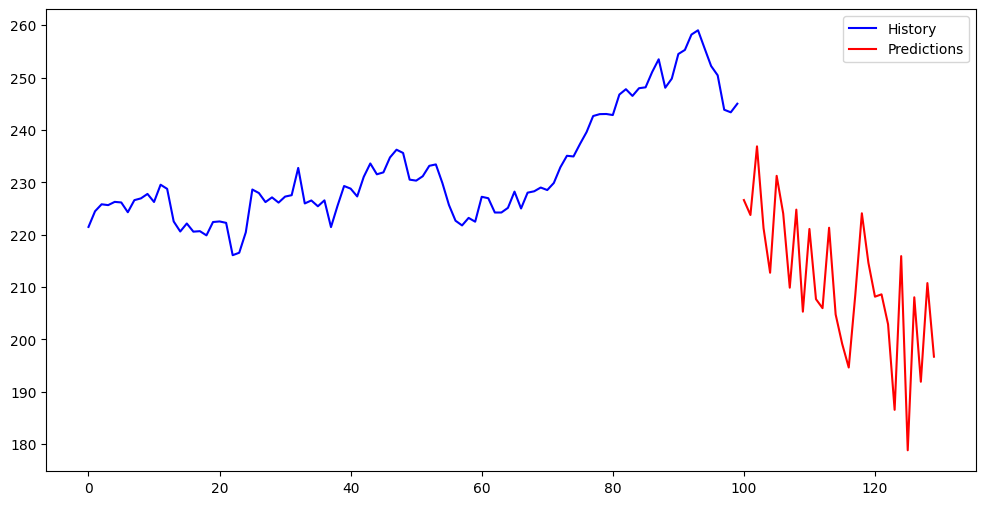

In [389]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

xa = list(range(len(history)))
ax.plot(xa, history, label="History", color="blue")

xb = list(range(len(history), len(history) + len(predictions)))
ax.plot(xb, predictions, label="Predictions", color="red")

ax.legend()
plt.show()